# Accessing DC2 data in PostgreSQL at NERSC

This notebook demonstrates use of the PostgreSQL database at NERSC.  Currently the only available dataset is the object catalog for Run1.1p.

### Prerequisites
* A file ~/.pgpass containing a line like this:

`nerscdb03.nersc.gov:54432:desc_dc2_drp:desc_dc2_drp_user:`_password_

Ask me (Joanne) what the value for _password_ should be.  This line allows you to use the desc_dc2_drp_user account, which has *SELECT* privileges on the database, without entering a password in plain text. There is a separate account for adding to or modifying the database. .pgpass must be protected so that only owner may read and write it.

* Access to the psycopg2 package which provides a Python interface to PostgreSQL. If it's not already available, do a local pip install.  Then you may have to 
  * put a line like this in your .bashrc.ext:  
    ```$DESCPYTHONPATH=~/.local/pythonpath3.6/site-packages```
  * restart your jupyter-dev server
  
This notebook uses psycopg2 directly for queries.  It is also possible to use sqlalchemy but you will still need a PostgreSQL driver. Of these psycopg2 is the most popular.


In [33]:
import psycopg2

import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

import pandas as pd

Make the db connection

In [34]:
dbname = 'desc_dc2_drp'
dbuser = 'desc_dc2_drp_user'
dbhost = 'nerscdb03.nersc.gov'
schema = 'run11p'
dbconfig = {'dbname' : dbname, 'user' : dbuser, 'host' : dbhost}
dbconn = psycopg2.connect(**dbconfig)

Tables for the Run1.1p data are in the *schema* (acts like a namespace) run11p. There is a special system schema, **information_schema**, which contains tables describing the structure of user tables. Of these **information_schema.columns** is most likely to be useful. The following lists all tables and views belonging to schema run11p. (I will use the convention of writing SQL keywords in all caps in queries. It's not necessary; the SQL interpreter ignores case.)

In [31]:
q1 = "SELECT DISTINCT table_name FROM information_schema.columns WHERE table_schema='{schema}' ORDER BY table_name".format(**locals())
with dbconn.cursor() as cursor:
    # Typically could have several queries in this block
    cursor.execute(q1)
    for record in cursor:
        print(record[0])

forced
forced2
forced3
_forced:part1
_forced:part2
_forced:part3
_forced:position
meas
meas2
meas3
meas4
_meas:part1
_meas:part2
_meas:part3
_meas:part4
_meas:position


The items with simple names, like **forced** or **meas2** are views; those starting with an underscore are the underlying tables.  The typical user will query only the views. Information is broken across several tables or views because there are too many columns for a single table. All tables and views have a field ```object_id``` which is convenient for joining when you don't know which view has the particular quantity you care about or when you need quantities from more than one view. Here is a list of all quantities in the view **forced**. It contains the most basic quantities for forced photometry.

In [32]:
tbl = 'forced'
q2 = "SELECT column_name, data_type FROM information_schema.columns WHERE table_schema='{schema}' AND table_name='{tbl}'".format(**locals())
with dbconn.cursor() as cursor:
    cursor.execute(q2)
    records = cursor.fetchall()
    print("There are {} columns in table {}.  They are:\n".format(len(records), tbl))
    print("Name                                                     Data Type")
    for record in records:
        print("{0!s:55}  {1!s:20}".format(record[0], record[1]) )

There are 567 columns in table forced.  They are:

Name                                                     Data Type
object_id                                                bigint              
ra                                                       double precision    
dec                                                      double precision    
skymap_id                                                integer             
tract                                                    integer             
patch                                                    integer             
patch_s                                                  text                
parent_id                                                bigint              
nchild                                                   integer             
isprimary                                                boolean             
detect_ispatchinner                                      boolean             
detect_istractinner     

Here is a similar query for the **meas** view.

In [22]:
tbl = 'meas'
q2 = "SELECT column_name, data_type FROM information_schema.columns WHERE table_schema='{schema}' AND table_name='{tbl}'".format(**locals())
with dbconn.cursor() as cursor:
    cursor.execute(q2)
    records = cursor.fetchall()
    print("There are {} columns in table {}.  They are:\n".format(len(records), tbl))
    print("Name                                                     Data Type")
    for record in records:
        print("{0!s:55}  {1!s:20}".format(record[0], record[1]) )

There are 1125 columns in table meas.  They are:

Name                                                     Data Type
object_id                                                bigint              
g_ra                                                     double precision    
g_dec                                                    double precision    
i_ra                                                     double precision    
i_dec                                                    double precision    
r_ra                                                     double precision    
r_dec                                                    double precision    
u_ra                                                     double precision    
u_dec                                                    double precision    
y_ra                                                     double precision    
y_dec                                                    double precision    
z_ra                     

Here is a query which counts up objects per tract and stores the results (queries return a list of tuples) in a pandas DataFrame.  

In [35]:
q3 = "SELECT tract, COUNT(object_id) FROM {schema}.forced WHERE isprimary GROUP BY tract".format(**locals())
with dbconn.cursor() as cursor:
    cursor.execute(q3)
    df = pd.DataFrame(cursor.fetchall(), columns=['tract', 'count'])
    print(df)
 

    tract   count
0    4430  103887
1    4431  155478
2    4432  137634
3    4433      11
4    4636    1446
5    4637  344628
6    4638  664922
7    4639  681528
8    4640  299132
9    4848  332054
10   4849  785795
11   4850  719228
12   4851  754903
13   4852   10778
14   5062   13640
15   5063  538497
16   5064  569393
17   5065  579765
18   5066  199661


The following can be compared with a similar query in the GCR Intro notebook.

In [ ]:
q4 = "SELECT ra,dec FROM {schema}.forced".format(**locals())
with dbconn.cursor() as cursor:
    %time cursor.execute(q4)
    %time records = cursor.fetchall()

### Color-color
Adapted from notebook object_pandas_stellar_locus in tutorials directory.
#### Using cuts
Put some cuts in a WHERE clause. 


In [44]:
global_cuts = ' isprimary '

min_SNR = 25
max_err = 1/min_SNR
band_cuts = ' g_cmodel_magsigma < {} AND i_cmodel_magsigma < {} AND r_cmodel_magsigma < {} '.format(max_err,max_err,max_err)
where = ' WHERE ' + global_cuts + ' AND ' + band_cuts  
q5 = "SELECT g_cmodel_mag as gmag,r_cmodel_mag AS rmag,i_cmodel_mag AS imag from {schema}.forced ".format(**locals()) + where
print(q5)
records = []
with dbconn.cursor() as cursor:
    cursor.execute(q5)
    records = cursor.fetchall()
    print('{} objects found '.format(len(records)))
    
df = pd.DataFrame(records, columns=['g_mag', 'r_mag', 'i_mag'])

SELECT g_cmodel_mag as gmag,r_cmodel_mag AS rmag,i_cmodel_mag AS imag from run11p.forced  WHERE  isprimary  AND  g_cmodel_magsigma < 0.04 AND i_cmodel_magsigma < 0.04 AND r_cmodel_magsigma < 0.04 
488783 objects found 


#### Plotting
Steal color-color plotting routine

In [45]:
def plot_color_color(z, color1, color2, range1=(-1, +2), range2=(-1, +2), bins=31):
    """Plot a color-color diagram.  Overlay stellar locus"""
    band1, band2 = color1[0], color1[-1]
    band3, band4 = color2[0], color2[-1]
    H, xedges, yedges = np.histogram2d(
        z['%s_mag' % band1] - z['%s_mag' % band2],
        z['%s_mag' % band3] - z['%s_mag' % band4],
        range=(range1, range2), bins=bins)
        
    zi = H.T
    xi = (xedges[1:] + xedges[:-1])/2
    yi = (yedges[1:] + yedges[:-1])/2

    cmap = 'viridis_r'
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xi, yi, zi, cmap=cmap)
    plt.contour(xi, yi, zi)
    plt.xlabel('%s-%s' % (band1, band2))
    plt.ylabel('%s-%s' % (band3, band4))

    #plot_stellar_locus(color1, color2)

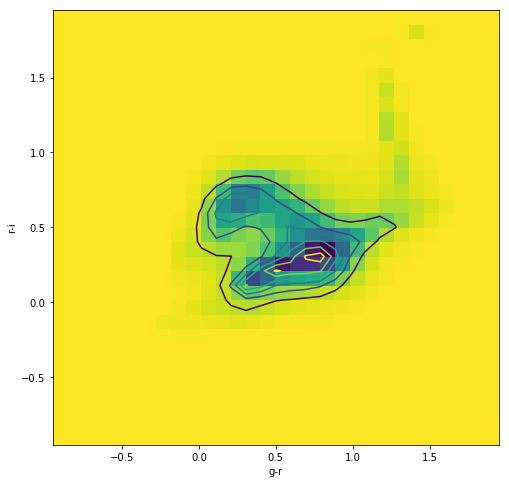

In [46]:
plot_color_color(df, 'gmr', 'rmi')

### Available functions
Many math functions from the c library have been wrapped and incorporated in an extension module installed in the database.  They have their normal c library names with the prefix `c_`.   They can be incorporated in queries as in this example using the command-line interface program **psql**:
```
desc_dc2_drp=> select c_asin(1.0);
     c_asin
-----------------
 1.5707963267949
```

There are also functions specially crafted for HSC or LSST catalogs with suggestive names like `patch_contains`, `tract_from_object_id`, `sky_to_pixel`,..